## Import libraries:

In [2]:
from imports import *

## 1. Preprocessing

The data corresponds to the Monte Carlo simulation of the SBND experiment. It was obtained by simulating the creation of neutrinos in the beam and their subsequent interaction in SBND, as well as the simulation of the detector's response to the particles resulting from the interaction of the neutrinos.

In [3]:
file_path = '/data/vidales/opana_tree_combined_v0411_both.root'
file = uproot.open(file_path)
optree = file['opanatree']['OpAnaTree'] # Tree con número de fotoelectrones
print("Keys in optree:", optree.keys())

Keys in optree: ['eventID', 'runID', 'subrunID', 'nuvX', 'nuvY', 'nuvZ', 'nuvT', 'nuvE', 'stepX', 'stepY', 'stepZ', 'stepT', 'dE', 'energydep', 'energydepX', 'energydepY', 'energydepZ', 'E', 'StartPx', 'StartPy', 'StartPz', 'EndPx', 'EndPy', 'EndPz', 'process', 'trackID', 'motherID', 'PDGcode', 'InTimeCosmics', 'InTimeCosmicsTime', 'dEtpc', 'dEpromx', 'dEpromy', 'dEpromz', 'dEspreadx', 'dEspready', 'dEspreadz', 'dElowedges', 'dEmaxedges', 'nopflash', 'flash_id', 'flash_time', 'flash_total_pe', 'flash_pe_v', 'flash_tpc', 'flash_y', 'flash_yerr', 'flash_z', 'flash_zerr', 'flash_x', 'flash_xerr', 'flash_ophit_time', 'flash_ophit_risetime', 'flash_ophit_starttime', 'flash_ophit_amp', 'flash_ophit_area', 'flash_ophit_width', 'flash_ophit_pe', 'flash_ophit_ch']


**Tarda 10min**

In [4]:
# Load variables to be predicted and associated data in a single step
hit_nuvX, hit_nuvT, hit_PE, hit_ch, hit_t, flash_time, dEpromx, dEpromy, dEpromz = (optree[key].array() for key in ['nuvX','nuvT', 'flash_ophit_pe', 'flash_ophit_ch', 'flash_ophit_time','flash_time', 'dEpromx', 'dEpromy', 'dEpromz'])

**To have good time variables we need two corrections. 1- ToF from beamline origin to upstream wall of detector (110m) ~ 367 ns is the minimum that happens in the case parent hadron decays just after the beryllium target. 2- Take module 19 because we care about the relative position with respect to the max of the bunches not the absolute time in the detector window ~ 1.8us**

In [4]:
ToF_inside = optree['nuvZ'].array() / 3E10 *1E9
print("ToF_inside:",ToF_inside, "ns")
ToF_outside = 110 / 3E8 * 1E9
print(f"ToF_outside {ToF_outside:.0f} ns")
ToF_outside_set0= ak.min(hit_nuvT - ToF_inside) 
print(f"ToF_outside_set0: {ToF_outside_set0:.0f} ns")
bunch_separation = 19
print(f"bunch_separation: {bunch_separation:.0f} ns")

ToF_inside: [[3.61], [4.69], [15, 16.3], [-0.0218], ..., [11.1], [8.32], [8.73], [7.4]] ns
ToF_outside 367 ns
ToF_outside_set0: 364 ns
bunch_separation: 19 ns


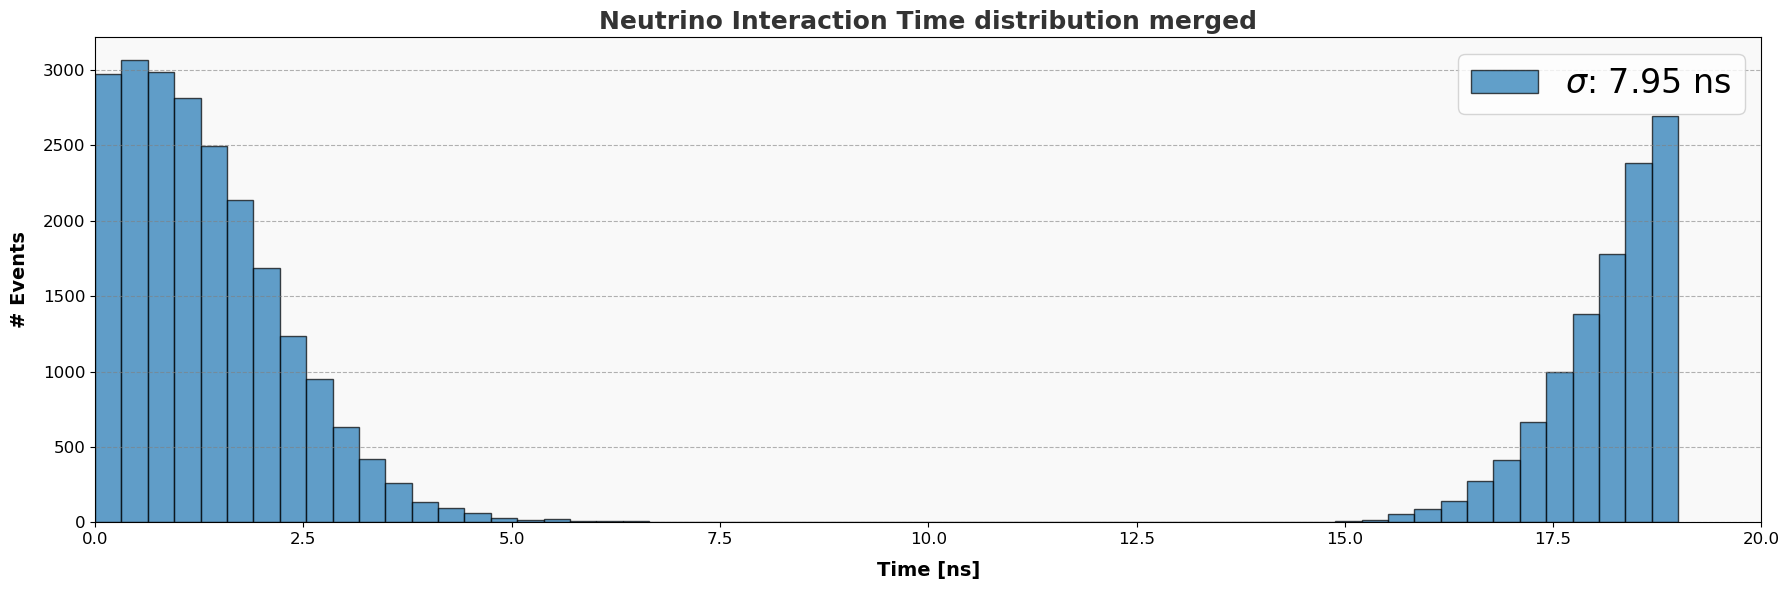

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak

# Assuming hit_nuvT, ToF_outside_set0, and ToF_inside are defined awkward arrays
# Calculate the difference and flatten it
difference = np.mod(ak.flatten(hit_nuvT - ToF_inside - ToF_outside), 19)  # +7 to center the distribution

# Calculate the standard deviation
std_dev = np.std(difference)

# Set up the plot
plt.figure(figsize=(18, 6))
plt.hist(difference, bins=60, color='#1f77b4', edgecolor='black', alpha=0.7, label=f'$\sigma$: {std_dev:.2f} ns')

# Customize the title and labels
plt.title('Neutrino Interaction Time distribution merged', fontsize=18, fontweight='bold', color='#333333')
plt.xlabel('Time [ns]', fontsize=14, labelpad=10, fontweight='bold')
plt.ylabel('# Events', fontsize=14, labelpad=10, fontweight='bold')

# Set axis limits
plt.xlim(0, 20)
plt.ylim(0, None)

# Enhance the grid and axis appearance
plt.grid(axis='y', linestyle='--', alpha=0.6, color='gray')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a light background color for the plot area to add contrast
plt.gca().set_facecolor('#f9f9f9')

# Add a legend
plt.legend(fontsize=24)

# Show the plot
plt.tight_layout()
plt.show()


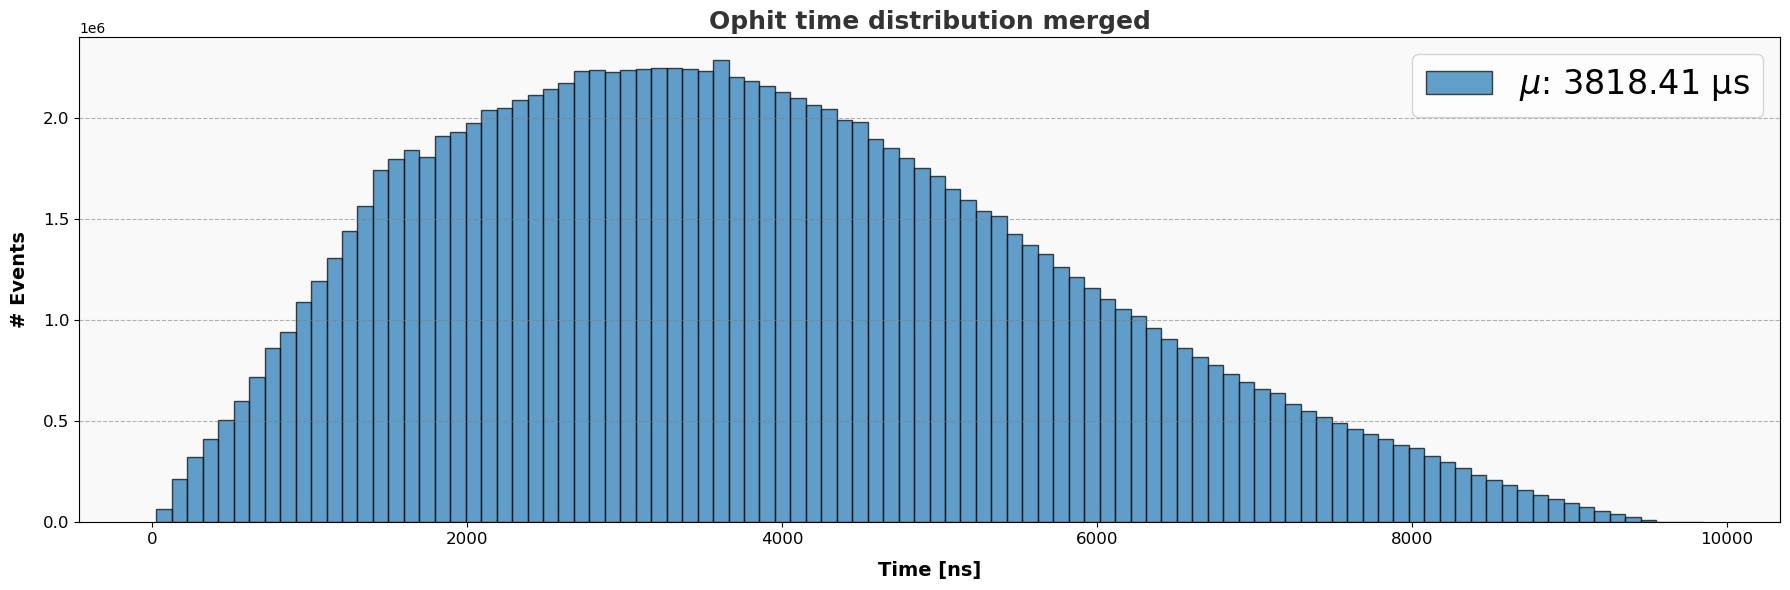

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak

# Assuming hit_nuvT, ToF_outside_set0, and ToF_inside are defined awkward arrays
# Calculate the difference and flatten it
difference = ak.to_numpy(ak.flatten(hit_t, axis=None))*1000 - ToF_outside 

# Calculate the standard deviation
std_dev = np.mean(difference)

# Set up the plot
plt.figure(figsize=(18, 6))
plt.hist(difference, bins=100, color='#1f77b4', edgecolor='black', alpha=0.7, label=f'$\mu$: {std_dev:.2f} μs')

# Customize the title and labels
plt.title('Ophit time distribution merged', fontsize=18, fontweight='bold', color='#333333')
plt.xlabel('Time [ns]', fontsize=14, labelpad=10, fontweight='bold')
plt.ylabel('# Events', fontsize=14, labelpad=10, fontweight='bold')

# Set axis limits
#plt.xlim(0, 20)
plt.ylim(0, None)

# Enhance the grid and axis appearance
plt.grid(axis='y', linestyle='--', alpha=0.6, color='gray')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))  # Forces scientific notation on the y-axis

# Add a light background color for the plot area to add contrast
plt.gca().set_facecolor('#f9f9f9')

# Add a legend
plt.legend(fontsize=24)

# Show the plot
plt.tight_layout()
plt.show()


The BNB is created by extracting protons from the Booster accelerator at Fermilab and impacting them on a beryllium target. The time structure of the delivered proton beam consists of a series of 81 bunches, each about 1.3 ns wide and 19 ns apart, defining a spill length of 1.6 µs

**opcion corregida**

In [11]:
hit_nuvT_c= np.mod(hit_nuvT - ToF_outside - ToF_inside, bunch_separation)
hit_t_c = hit_t*1000 - ToF_outside
#ToF outside solo añade un shift global. ToF inside no se le mete a hit_t porque debe intentar predecirlo. Hit_t no sé si tiene sentido hacer el módulo 19 pero creo que no.

**opcion sin corregir**

In [5]:
hit_nuvT_c= hit_nuvT
hit_t_c = hit_t
#ToF outside solo añade un shift global. ToF inside no se le mete a hit_t porque debe intentar predecirlo. Hit_t no sé si tiene sentido hacer el módulo 19 pero creo que no.

In [6]:
# Filter subarrays: keep only those with one neutrino interaction in hit_nuvT
hit_nuvX_f, hit_nuvT_fc, hit_PE_f, hit_ch_f, hit_t_fc, flash_time_f, dEpromx_f, dEpromy_f, dEpromz_f = zip(*[
    (subarray_nuvX, subarray_nuvT, subarray_PE, subarray_ch, subarray_t, subarray_flash_time, subarray_dEpromx, subarray_dEpromy, subarray_dEpromz)
    for subarray_nuvX, subarray_nuvT, subarray_PE, subarray_ch, subarray_t, subarray_flash_time, subarray_dEpromx, subarray_dEpromy, subarray_dEpromz
    in zip(hit_nuvX, hit_nuvT_c, hit_PE, hit_ch, hit_t_c, flash_time, dEpromx, dEpromy, dEpromz)
    if len(subarray_nuvT) == 1 
])

In [7]:
# Convert awkward arrays to Arrow tables
ophit_variables = pa.Table.from_pydict({
    'hit_nuvX_f': ak.to_list(hit_nuvX_f),
    'hit_nuvT_fc': ak.to_list(hit_nuvT_fc),
    'hit_PE_f': ak.to_list(hit_PE_f),
    'hit_ch_f': ak.to_list(hit_ch_f),
    'hit_t_fc': ak.to_list(hit_t_fc),
    'flash_time_f': ak.to_list(flash_time_f),
    'dEpromx_f': ak.to_list(dEpromx_f),
    'dEpromy_f': ak.to_list(dEpromy_f),
    'dEpromz_f': ak.to_list(dEpromz_f)
})

# Save to Parquet file
pq.write_table(ophit_variables, 'saved_archives/ophit_variables_noc.parquet')

# To load some variables from the parquet file, use the following code
# table = pq.read_table('saved_archives/ophit_variables.parquet')
# hit_nuvT_f = ak.from_iter(table.column('hit_nuvT_f').to_pylist())

## 2. PE and time matrix

**With the complete data it takes ~ 14min**

In [8]:
pe_matrix, time_matrix = process_photoelectrons(hit_PE_f, hit_ch_f, hit_t_fc)

# Save the matrices to a CSV file
np.savetxt("saved_archives/pe_matrix_&_time_matrix/pe_matrix_noc.csv", pe_matrix, delimiter=",")
np.savetxt("saved_archives/pe_matrix_&_time_matrix/time_matrix_noc.csv", time_matrix, delimiter=",")